<a href="https://colab.research.google.com/github/HST0077/Financial-Engineering-Python/blob/main/Stochastics_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import time

class Timer:
    def __init__(self):
        self.start_time = None
        self.end_time = None

    def tic(self):
        self.start_time = time.time()

    def toc(self):
        self.end_time = time.time()
        if self.start_time is None:
            print("tic() 메서드를 호출하여 시작 시간을 설정하세요.")
        else:
            elapsed_time = self.end_time - self.start_time
            print("코드 실행 시간:", elapsed_time, "초")

**정규분포 난수 생성하고 검증하기**

In [ ]:
# normal random variate
from scipy.stats import norm

# random number 생산
# 평균이 4이고 표준편차 10인 정규분포 난수 생성
D=norm.rvs(4,10,size=1000)
# 자료 검증
a,b=norm.fit(D) # a,b는 평균,표준편차
a,b**2

(4.190956592449356, 98.96989262556633)

image.png

평균:0, 분산:1
코드 실행 시간: 1.9365754127502441 초


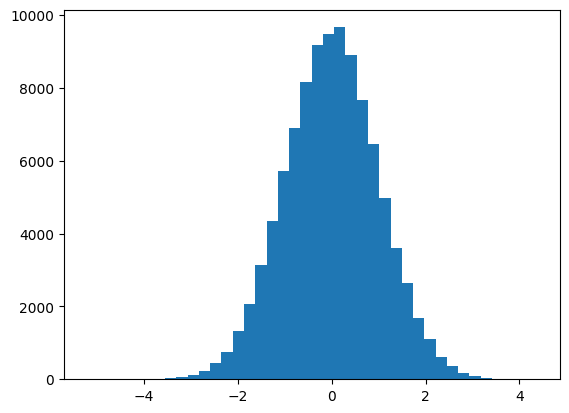

In [ ]:
timer = Timer()
timer.tic()

import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

sim=100000 #시뮬레이션 횟수
N=300 # 시간간격의 갯수
s=np.sqrt(1/N) # 분산을 표준편차화
# N(0,s)을 따르는 [N,sim] 크기의 정규난수 생성
dW=norm.rvs(0,s,size=[N,sim])
sumW=dW.sum(axis=0) # 각 열별로 누적합을 구함
plt.hist(sumW,bins=40) # 히스토그램으로 그리기
mu,sig=norm.fit(sumW)
print(f'평균:{0}, 분산:{1}'.format(mu,sig**2))

timer.toc()

In [ ]:
# GPU를 활용하기 위해 cupy 호출
# conda install -c conda-forge cupy
import cupy as cp
from scipy.stats import norm

def BMsum_gpu(T, sim, N_intervals):
    # T: maturity in years
    # sim: 시뮬레이션 횟수
    # N_intervals: 시간을 몇 개로 쪼갤 것인지 지정
    N = T * N_intervals  # 만기를 감안한 시간간격의 갯수
    s = cp.sqrt(1 / N_intervals)  # 분산을 표준편차화
    # N(0,s)을 따르는 [N, sim] 크기의 정규난수 생성
    dW = cp.random.normal(0, s, size=(N, sim))
    sumW = cp.sum(dW, axis=0)  # 각 열별로 누적합을 구함
    mu, sig = norm.fit(cp.asnumpy(sumW))
    return mu, sig ** 2

코드 실행 시간: 2.6111502647399902 초


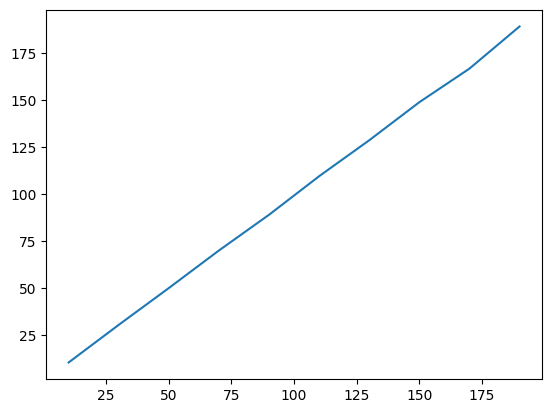

In [ ]:
timer.tic()

X=np.arange(10,201,20)
Y=np.zeros(len(X))
for i,n  in enumerate(X):
    Y[i]=BMsum_gpu(n,10000,300)[1] # 분산 값만 저장

plt.plot(X,Y)

timer.toc()

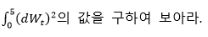

평균: 5.000141748665811 분산: 0.02675378510888252


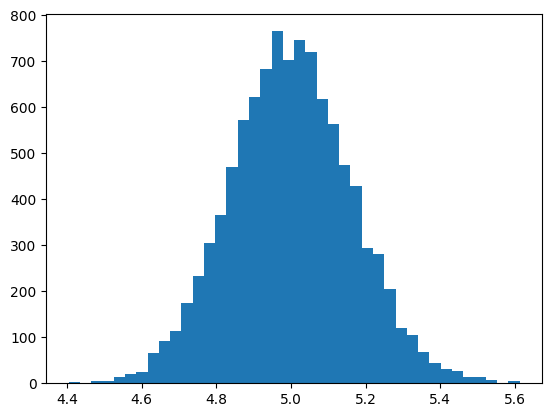

In [ ]:
import cupy as cp
from scipy.stats import norm
import matplotlib.pyplot as plt

# 만기1을 몇 개의 시간간격으로 쪼갤지 선정
N_intervals=365
sim=10000 # simulation 회수
N=5*N_intervals # 만기를 감안한 시간간격의 갯수
s=cp.sqrt(1/N_intervals) # 분산을 표준편차화
# N(0,s)을 따르는 [N,sim] 크기의 정규난수 생성
dW = cp.random.normal(0, s, size=(N, sim))
dW2=dW**2 # 각 원소를 제곱
col_sum=dW2.sum(axis=0) # 각 열별로 누적합을 구함
plt.hist(cp.asnumpy(col_sum),bins=40)
mu, sig = norm.fit(cp.asnumpy(col_sum))
print('평균:',mu, '분산:',sig**2)

In [ ]:
def BMsum2_gpu(T,sim,N_intervals):
    import cupy as cp
    from scipy.stats import norm
    import matplotlib.pyplot as plt
    # T: maturity in years
    # sim: 시뮬레이션 횟수
    # N_intervals: 시간을 몇 개로 쪼갤 것인지 지정
    N=T*N_intervals # 만기를 감안한 시간간격의 갯수
    s=cp.sqrt(1/N_intervals) # 분산을 표준편차화
    # N(0,s)을 따르는 [N,sim] 크기의 정규난수 생성
    dW = cp.random.normal(0, s, size=(N, sim))
    dW2=dW**2 # 각 원소를 제곱
    col_sum=dW2.sum(axis=0) # 각 열별로 누적합을 구함
    mu, sig = norm.fit(cp.asnumpy(col_sum))
    return mu, sig**2

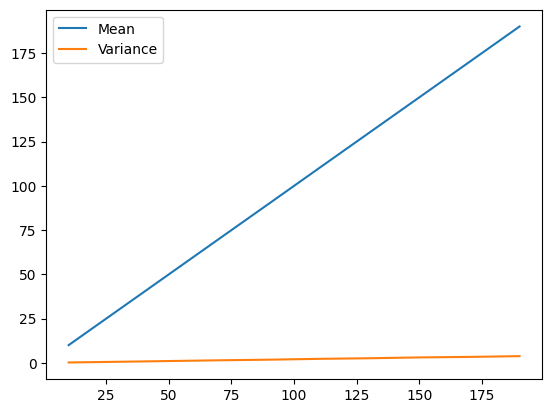

코드 실행 시간: 1.8139076232910156 초


In [ ]:
timer.tic()

X=np.arange(10,201,20)
M=np.zeros(len(X))
S=np.zeros(len(X))

for i,n  in enumerate(X):
    a,b=BMsum2_gpu(n,10000,100)
    M[i]=a #평균값 저장
    S[i]=b # 분산값 저장

plt.plot(X, M, label='Mean')
plt.plot(X, S, label='Variance')

plt.legend()
plt.show()

timer.toc()

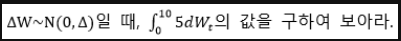

In [1]:
def BMsum_withC_gpu(a,b, CIntegral, sim, N_intervals):
    import cupy as cp
    from scipy.stats import norm
    # CIntegral: 적분대상으로 상수
    # sim: 시뮬레이션 횟수
    # N_intervals: 시간을 몇 개로 쪼갤 것인지 지정
    T=b-a
    N = T * N_intervals  # 만기를 감안한 시간간격의 갯수
    s = cp.sqrt(1 / N_intervals)  # 분산을 표준편차화
    # N(0,s)을 따르는 [N, sim] 크기의 정규난수 생성
    dW = cp.random.normal(0, s, size=(N, sim))
    sumW = cp.sum(CIntegral*dW, axis=0)  # 각 열별로 누적합을 구함
    mu, sig = norm.fit(cp.asnumpy(sumW))
    return mu, sig ** 2

평균: -0.016760646160010786 분산: 35.84301445694966


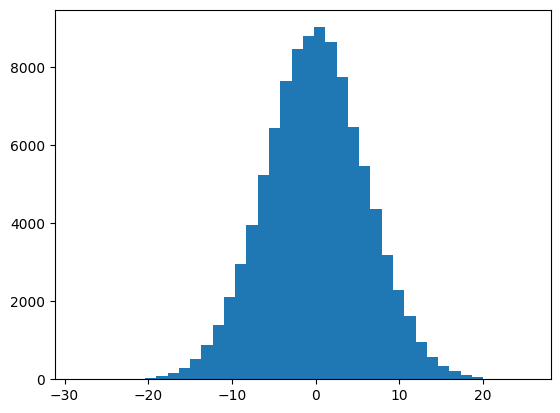

In [2]:
import cupy as cp
from scipy.stats import norm
import matplotlib.pyplot as plt

# CIntegral: 적분대상으로 상수
# sim: 시뮬레이션 횟수
# N_intervals: 시간을 몇 개로 쪼갤 것인지 지정

a,b=1,5
CIntegral=3
sim,N_intervals=100000,500
T=b-a
N = T * N_intervals  # 만기를 감안한 시간간격의 갯수
s = cp.sqrt(1 / N_intervals)  # 분산을 표준편차화
# N(0,s)을 따르는 [N, sim] 크기의 정규난수 생성
dW = cp.random.normal(0, s, size=(N, sim))
sumW = cp.sum(CIntegral*dW, axis=0)  # 각 열별로 누적합을 구함
plt.hist(cp.asnumpy(sumW),bins=40) # histogram으로 표현
mu, sig = norm.fit(cp.asnumpy(sumW))
print('평균:',mu, '분산:',sig**2)

In [3]:
BMsum_withC_gpu(1,5,3,100000,500)

(0.0026768337160785064, 35.89636305572951)

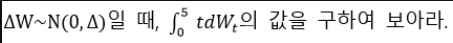

In [4]:
# cumsum의 이해
import numpy as np

D=np.random.randint(10,size=[4,5])
D_row=np.cumsum(D,axis=0) # 행방향 누적행렬
D_col=np.cumsum(D,axis=1) # 열방향 누적행렬
D,D_row,D_col

(array([[6, 7, 9, 5, 8],
        [7, 5, 3, 4, 9],
        [7, 9, 7, 0, 7],
        [5, 9, 1, 8, 9]]),
 array([[ 6,  7,  9,  5,  8],
        [13, 12, 12,  9, 17],
        [20, 21, 19,  9, 24],
        [25, 30, 20, 17, 33]]),
 array([[ 6, 13, 22, 27, 35],
        [ 7, 12, 15, 19, 28],
        [ 7, 16, 23, 23, 30],
        [ 5, 14, 15, 23, 32]]))

In [5]:
# tile의 이해
D1=np.random.randint(10,size=[2,3])

# D1 모양을 첫번째 축으로 3번,
# 두번째 축방향으로 4번 복제함
out=np.tile(D1,(3,4))

D1,out

(array([[6, 2, 7],
        [3, 9, 0]]),
 array([[6, 2, 7, 6, 2, 7, 6, 2, 7, 6, 2, 7],
        [3, 9, 0, 3, 9, 0, 3, 9, 0, 3, 9, 0],
        [6, 2, 7, 6, 2, 7, 6, 2, 7, 6, 2, 7],
        [3, 9, 0, 3, 9, 0, 3, 9, 0, 3, 9, 0],
        [6, 2, 7, 6, 2, 7, 6, 2, 7, 6, 2, 7],
        [3, 9, 0, 3, 9, 0, 3, 9, 0, 3, 9, 0]]))

평균: 0.004290172038687923 분산: 41.721211850193946


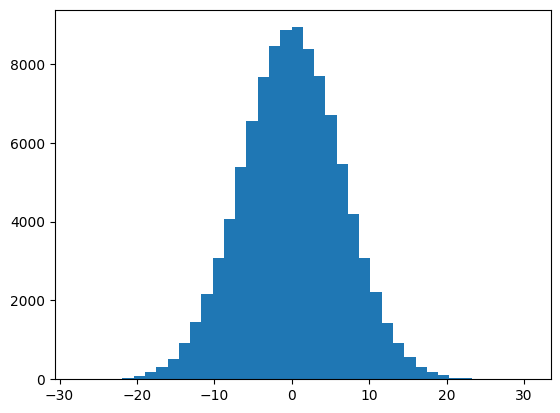

In [6]:
import cupy as cp
from scipy.stats import norm
import matplotlib.pyplot as plt

# sim: 시뮬레이션 횟수
# N_intervals: 시간을 몇 개로 쪼갤 것인지 지정
a,b=0,5
sim,N_intervals=100000,500
T=b-a
N = T * N_intervals  # 만기를 감안한 시간간격의 갯수
s = cp.sqrt(1 / N_intervals)  # 분산을 표준편차화
# N(0,s)을 따르는 [N, sim] 크기의 정규난수 생성
dW = cp.random.normal(0, s, size=(N, sim))

# integrand 부분을 함수형태로 만들어 주기
t_col=cp.arange(1,N+1)*((b-a)/N) # ih의 값 생성
t_col = t_col[:, cp.newaxis]  # 열(column)로 갖는 행렬로 변환
t_mat=cp.tile(t_col,(1,sim)) # 열 방향으로 sim 개수만큼 복제

# 동일한 형태의 두 행렬의 같은 원소의 곱을 만들어줌
Integrand=t_mat*dW # 행렬의 곱이 아님

# 행방향으로 누적합을 구해가다가 마지막행을 추출
col_sum = cp.cumsum(Integrand, axis=0)[-1,:]

col_sum_np=cp.asnumpy(col_sum) # numpy array로 변환
plt.hist(col_sum_np,bins=40) # histogram으로 표현
mu, sig = norm.fit(col_sum_np)
print('평균:',mu, '분산:',sig**2)

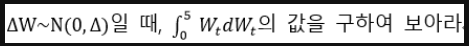

In [7]:
# 일반 정적분 문제 풀기
T,N=5,100000
h=T/N
# N+1개의 시점 생성
t_ax=np.linspace(0,T,N+1)

# 직사각형의 왼쪽 함수값을 높이로 구함
left_sum=np.sum(t_ax[:-1]*h)
print('왼쪽을 기준으로:',left_sum)

# 직사각형의 오른쪽 함수값을 높이로 구함
right_sum=np.sum(t_ax[1:]*h)
print('오른쪽을 기준으로:',right_sum)

# 직사각형의 중앙값을 높이로 구함
center_sum=np.sum((t_ax[:-1]+t_ax[1:])/2*h)
print('중앙값을 기준으로:',center_sum)

왼쪽을 기준으로: 12.499875000000003
오른쪽을 기준으로: 12.500125
중앙값을 기준으로: 12.500000000000002


평균: 0.06277243997410781 분산: 13.15720192988647


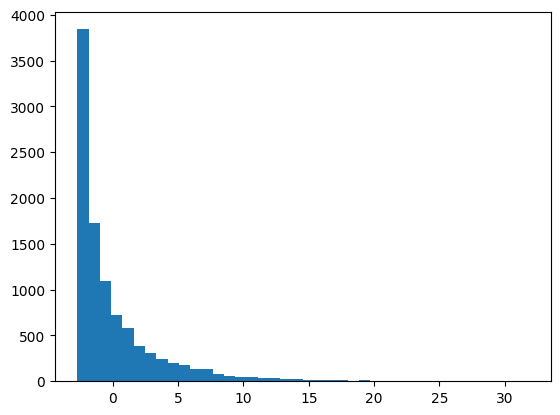

In [9]:
import cupy as cp
from scipy.stats import norm
import matplotlib.pyplot as plt

# sim: 시뮬레이션 횟수
# N_intervals: 시간을 몇 개로 쪼갤 것인지 지정
a,b=0,5
sim,N_intervals=10000,500
T=b-a
N = T * N_intervals  # 만기를 감안한 시간간격의 갯수
s = cp.sqrt(1 / N_intervals)  # 분산을 표준편차화
# N(0,s)을 따르는 [N, sim] 크기의 정규난수 생성
dW = cp.random.normal(0, s, size=(N, sim))

# integrand 부분을 함수형태로 만들어 주기
W=cp.cumsum(dW,axis=0) # 행으로 계속 누적하여 Wt 행렬 생성
# 추가할 행 생성
zero_row = cp.zeros((1, W.shape[1]), dtype=W.dtype)
# 0으로 이루어진 행을 W의 첫 행에 추가
W = cp.vstack([zero_row, W]) # (N+1,sim)의 행렬로 만든다.

# 동일한 형태의 두 행렬의 같은 원소의 곱을 만들어줌
# 왼쪽에서 높이를 구함
Integrand=W[:-1]*dW # 행렬의 곱이 아님

# 행방향으로 누적합을 구해가다가 마지막행을 추출
col_sum = cp.cumsum(Integrand, axis=0)[-1,:]

col_sum_np=cp.asnumpy(col_sum) # numpy array로 변환
plt.hist(col_sum_np,bins=40) # histogram으로 표현
mu, sig = norm.fit(col_sum_np)
print('평균:',mu, '분산:',sig**2)

In [10]:
# Ito integral 수식에 의한 값
# W행렬의 마지막행에 W_T 값들이 존재함
W_T=cp.asnumpy(W[-1,:])
T=b-a
mu, sig = norm.fit(0.5*(W_T**2-T))
print('평균:',mu, '분산:',sig**2)

평균: 0.06354153675420542 분산: 13.164861298600075


평균: 5.064310633534302 분산: 13.182417644914942


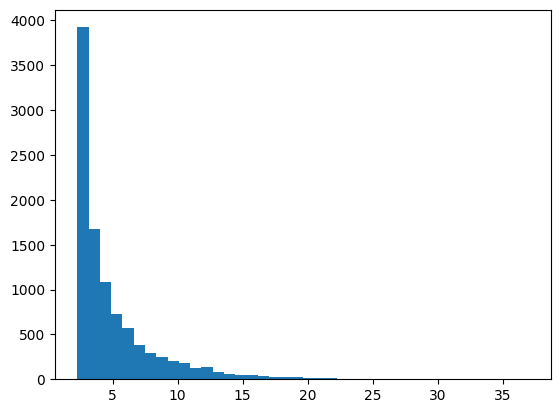

In [11]:
# 오른쪽에서 높이를 구함
Integrand=W[1:]*dW # 행렬의 곱이 아님

# 행방향으로 누적합을 구해가다가 마지막행을 추출
col_sum = cp.cumsum(Integrand, axis=0)[-1,:]

col_sum_np=cp.asnumpy(col_sum) # numpy array로 변환
plt.hist(col_sum_np,bins=40) # histogram으로 표현
mu, sig = norm.fit(col_sum_np)
print('평균:',mu, '분산:',sig**2)

----------------------------------
----- 시뮬레이션에 의한 값 --------
----------------------------------
평균: 2.5635415367542054 분산: 13.164861298600078
----------------------------------
--- 스트라토노비치 수식에 의한 값 ---
----------------------------------
평균: 2.5635415367542054 분산: 13.164861298600078


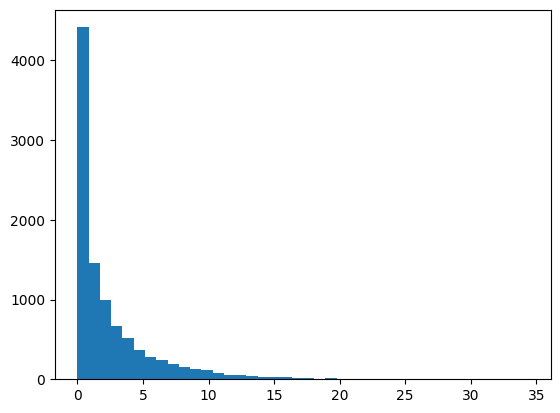

In [12]:
# Stratonovich integral
# 중앙값에서 높이를 구함
Integrand=(W[1:]+W[:-1])/2*dW # 행렬의 곱이 아님

# 행방향으로 누적합을 구해가다가 마지막행을 추출
col_sum = cp.cumsum(Integrand, axis=0)[-1,:]

col_sum_np=cp.asnumpy(col_sum) # numpy array로 변환
plt.hist(col_sum_np,bins=40) # histogram으로 표현
mu, sig = norm.fit(col_sum_np)
print('----------------------------------')
print('----- 시뮬레이션에 의한 값 --------')
print('----------------------------------')
print('평균:',mu, '분산:',sig**2)
print('----------------------------------')
print('--- 스트라토노비치 수식에 의한 값 ---')
print('----------------------------------')
mu, sig = norm.fit(0.5*(W_T**2))
print('평균:',mu, '분산:',sig**2)

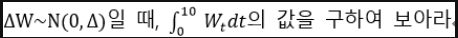

평균: -0.034942306041662985 분산: 327.0159862095389


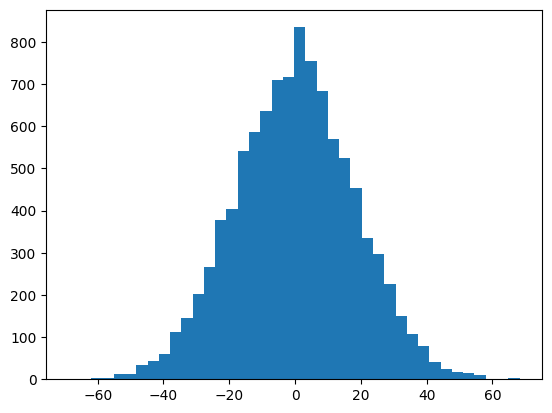

In [14]:
import cupy as cp
from scipy.stats import norm
import matplotlib.pyplot as plt

# sim: 시뮬레이션 횟수
# N_intervals: 시간을 몇 개로 쪼갤 것인지 지정
a,b=0,10
sim,N_intervals=10000,500
T=b-a
N = T * N_intervals  # 만기를 감안한 시간간격의 갯수
dt=T/N
s = cp.sqrt(1 / N_intervals)  # 분산을 표준편차화
# N(0,s)을 따르는 [N, sim] 크기의 정규난수 생성
dW = cp.random.normal(0, s, size=(N, sim))

# integrand 부분을 함수형태로 만들어 주기
W=cp.cumsum(dW,axis=0) # 행으로 계속 누적하여 Wt 행렬 생성
# 추가할 행 생성
zero_row = cp.zeros((1, W.shape[1]), dtype=W.dtype)
# 0으로 이루어진 행을 W의 첫 행에 추가
W = cp.vstack([zero_row, W]) # (N+1,sim)의 행렬로 만든다.

# 왼쪽에서 높이를 구함
Integrand=W[:-1]*dt

# 행방향으로 누적합을 구해가다가 마지막행을 추출
col_sum = cp.cumsum(Integrand, axis=0)[-1,:]

col_sum_np=cp.asnumpy(col_sum) # numpy array로 변환
plt.hist(col_sum_np,bins=40) # histogram으로 표현
mu, sig = norm.fit(col_sum_np)
print('평균:',mu, '분산:',sig**2)

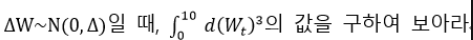

평균: -1.9670774277262462 분산: 12795.516963559112


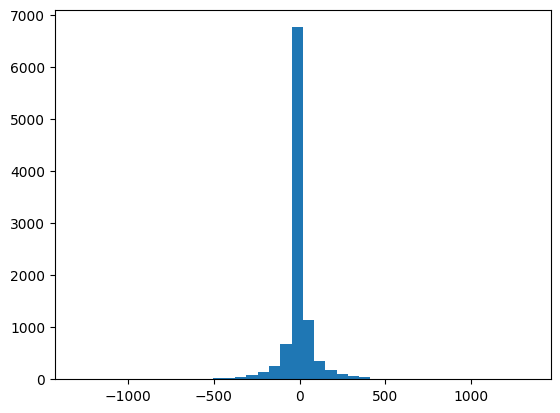

In [16]:
import cupy as cp
from scipy.stats import norm
import matplotlib.pyplot as plt

a,b=0,10
sim,N_intervals=10000,350
T=b-a
N = T * N_intervals  # 만기를 감안한 시간간격의 갯수
dt=T/N
s = cp.sqrt(1 / N_intervals)  # 분산을 표준편차화
# N(0,s)을 따르는 [N, sim] 크기의 정규난수 생성
dW = cp.random.normal(0, s, size=(N, sim))

# integrand 부분을 함수형태로 만들어 주기
W=cp.cumsum(dW,axis=0) # 행으로 계속 누적하여 Wt 행렬 생성
# 추가할 행 생성
zero_row = cp.zeros((1, W.shape[1]), dtype=W.dtype)
# 0으로 이루어진 행을 W의 첫 행에 추가
W = cp.vstack([zero_row, W]) # (N+1,sim)의 행렬로 만든다.

# W의 마지막 행을 세제곱한다
last_np=cp.asnumpy(W[-1,:]**3) # numpy array로 변환
plt.hist(last_np,bins=40) # histogram으로 표현
mu, sig = norm.fit(last_np)
print('평균:',mu, '분산:',sig**2)

평균: -1.96600872335036 분산: 12786.860517163386


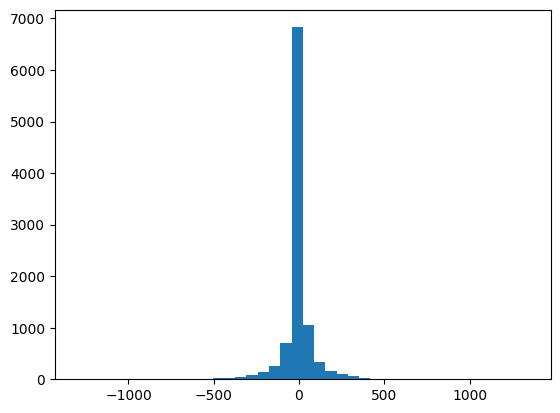

In [17]:
# Ito integrand
Integrand=3*W[:-1]*dt + 3*W[:-1]*W[:-1]*dW

# 행방향으로 누적합을 구해가다가 마지막행을 추출
col_sum = cp.cumsum(Integrand, axis=0)[-1,:]

col_sum_np=cp.asnumpy(col_sum) # numpy array로 변환
plt.hist(col_sum_np,bins=40) # histogram으로 표현
mu, sig = norm.fit(col_sum_np)
print('평균:',mu, '분산:',sig**2)

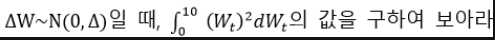

평균: 0.6003179877873782 분산: 989.8988562317415


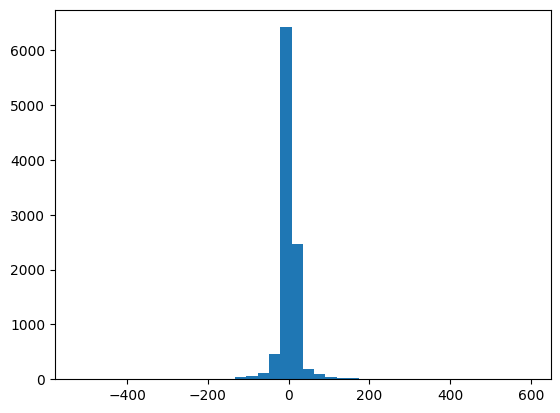

In [19]:
import cupy as cp
from scipy.stats import norm
import matplotlib.pyplot as plt

a,b=0,10
sim,N_intervals=10000,350
T=b-a
N = T * N_intervals  # 만기를 감안한 시간간격의 갯수
dt=T/N
s = cp.sqrt(1 / N_intervals)  # 분산을 표준편차화
# N(0,s)을 따르는 [N, sim] 크기의 정규난수 생성
dW = cp.random.normal(0, s, size=(N, sim))

# integrand 부분을 함수형태로 만들어 주기
W=cp.cumsum(dW,axis=0) # 행으로 계속 누적하여 Wt 행렬 생성
# 추가할 행 생성
zero_row = cp.zeros((1, W.shape[1]), dtype=W.dtype)
# 0으로 이루어진 행을 W의 첫 행에 추가
W = cp.vstack([zero_row, W]) # (N+1,sim)의 행렬로 만든다.

# Ito integrand
Integrand= W[:-1]*W[:-1]*dW

# 행방향으로 누적합을 구해가다가 마지막행을 추출
col_sum = cp.cumsum(Integrand, axis=0)[-1,:]

col_sum_np=cp.asnumpy(col_sum) # numpy array로 변환
plt.hist(col_sum_np,bins=40) # histogram으로 표현
mu, sig = norm.fit(col_sum_np)
print('평균:',mu, '분산:',sig**2)

평균: 0.6106825224247834 분산: 990.4526284649478


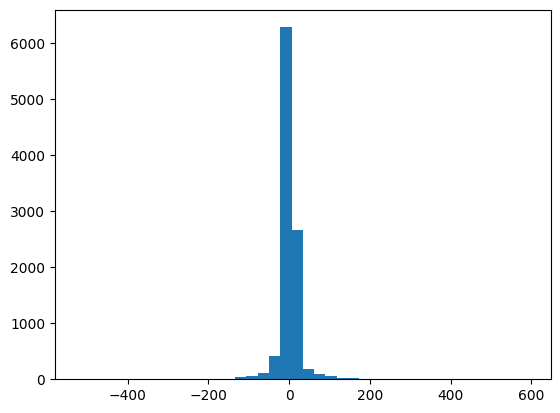

In [20]:
# Ito integrand
Integrand= -W[:-1]*dt

# 행방향으로 누적합을 구해가다가 마지막행을 추출
col_sum = cp.cumsum(Integrand, axis=0)[-1,:]+(1/3)*W[-1,:]**3

col_sum_np=cp.asnumpy(col_sum) # numpy array로 변환
plt.hist(col_sum_np,bins=40) # histogram으로 표현
mu, sig = norm.fit(col_sum_np)
print('평균:',mu, '분산:',sig**2)

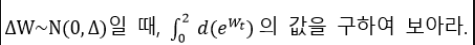

평균: 1.760180290134581 분산: 51.024355054453544


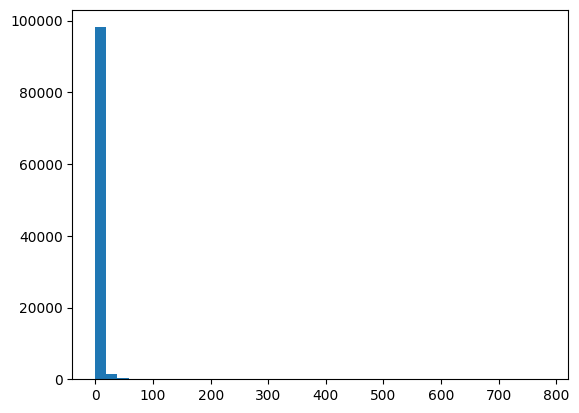

In [21]:
import cupy as cp
from scipy.stats import norm
import matplotlib.pyplot as plt

a,b=0,2
sim,N_intervals=100000,350
T=b-a
N = T * N_intervals  # 만기를 감안한 시간간격의 갯수
dt=T/N
s = cp.sqrt(1 / N_intervals)  # 분산을 표준편차화
# N(0,s)을 따르는 [N, sim] 크기의 정규난수 생성
dW = cp.random.normal(0, s, size=(N, sim))

# integrand 부분을 함수형태로 만들어 주기
W=cp.cumsum(dW,axis=0) # 행으로 계속 누적하여 Wt 행렬 생성
# 추가할 행 생성
zero_row = cp.zeros((1, W.shape[1]), dtype=W.dtype)
# 0으로 이루어진 행을 W의 첫 행에 추가
W = cp.vstack([zero_row, W]) # (N+1,sim)의 행렬로 만든다.

# Ito integrand
Integrand= cp.exp(W[1:])-cp.exp(W[:-1])

# 행방향으로 누적합을 구해가다가 마지막행을 추출
col_sum = cp.cumsum(Integrand, axis=0)[-1,:]

col_sum_np=cp.asnumpy(col_sum) # numpy array로 변환
plt.hist(col_sum_np,bins=40) # histogram으로 표현
mu, sig = norm.fit(col_sum_np)
print('평균:',mu, '분산:',sig**2)

평균: 1.758866615167919 분산: 50.72528787697227


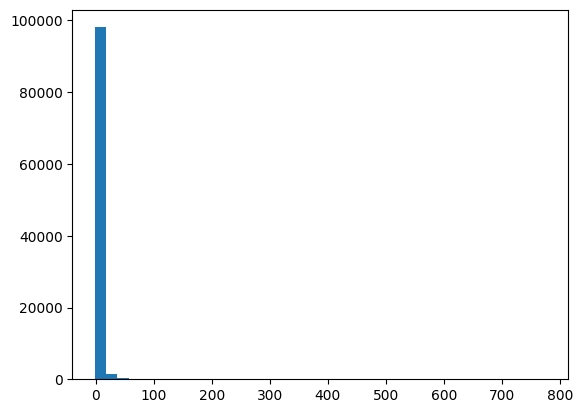

In [22]:
# Ito integrand
Integrand= cp.exp(W[:-1])*dW+0.5*cp.exp(W[:-1])*dt

# 행방향으로 누적합을 구해가다가 마지막행을 추출
col_sum = cp.cumsum(Integrand, axis=0)[-1,:]

col_sum_np=cp.asnumpy(col_sum) # numpy array로 변환
plt.hist(col_sum_np,bins=40) # histogram으로 표현
mu, sig = norm.fit(col_sum_np)
print('평균:',mu, '분산:',sig**2)

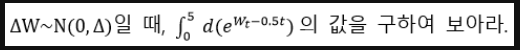

평균: -0.01338624025645677 분산: 65.22961086892607


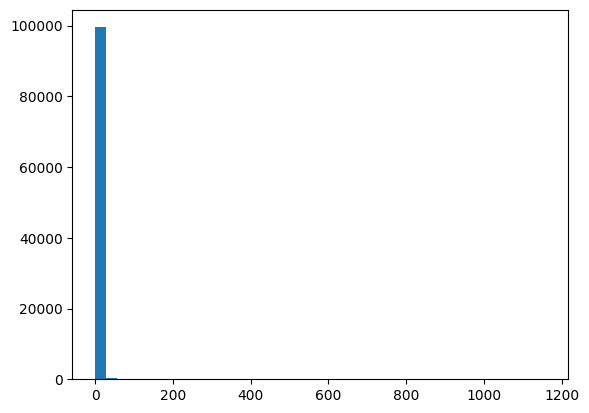

In [23]:
import cupy as cp
from scipy.stats import norm
import matplotlib.pyplot as plt

a,b=0,5
sim,N_intervals=100000,350
T=b-a
N = T * N_intervals  # 만기를 감안한 시간간격의 갯수
dt=T/N
s = cp.sqrt(1 / N_intervals)  # 분산을 표준편차화

# time 행렬 작성하기
t_col=cp.arange(1,N+1)*((b-a)/N) # ih의 값 생성
t_col = t_col[:, cp.newaxis]  # 열(column)로 갖는 행렬로 변환
t_mat=cp.tile(t_col,(1,sim)) # 열 방향으로 sim 개수만큼 복제
zero_row = cp.zeros((1, t_mat.shape[1]), dtype=t_mat.dtype)
# 0으로 이루어진 행을 W의 첫 행에 추가
t_mat = cp.vstack([zero_row, t_mat]) # (N+1,sim)의 행렬로 만든다.

# N(0,s)을 따르는 [N, sim] 크기의 정규난수 생성
dW = cp.random.normal(0, s, size=(N, sim))
# integrand 부분을 함수형태로 만들어 주기
W=cp.cumsum(dW,axis=0) # 행으로 계속 누적하여 Wt 행렬 생성
# 추가할 행 생성
zero_row = cp.zeros((1, W.shape[1]), dtype=W.dtype)
# 0으로 이루어진 행을 W의 첫 행에 추가
W = cp.vstack([zero_row, W]) # (N+1,sim)의 행렬로 만든다.

# Ito integrand
Integrand= cp.exp(W[1:]-0.5*t_mat[1:])-cp.exp(W[:-1]-0.5*t_mat[:-1])

# 행방향으로 누적합을 구해가다가 마지막행을 추출
col_sum = cp.cumsum(Integrand, axis=0)[-1,:]

col_sum_np=cp.asnumpy(col_sum) # numpy array로 변환
plt.hist(col_sum_np,bins=40) # histogram으로 표현
mu, sig = norm.fit(col_sum_np)
print('평균:',mu, '분산:',sig**2)

평균: -0.014227688502854403 분산: 64.87155705122971


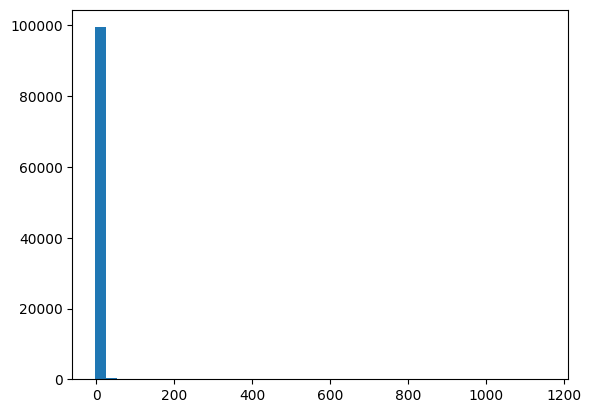

In [24]:
# Ito integrand
Integrand= cp.exp(W[:-1]-0.5*t_mat[:-1])*dW

# 행방향으로 누적합을 구해가다가 마지막행을 추출
col_sum = cp.cumsum(Integrand, axis=0)[-1,:]

col_sum_np=cp.asnumpy(col_sum) # numpy array로 변환
plt.hist(col_sum_np,bins=40) # histogram으로 표현
mu, sig = norm.fit(col_sum_np)
print('평균:',mu, '분산:',sig**2)

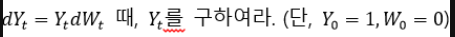

In [25]:
def fun_Y(T,sim,N_intervals):
    import cupy as cp
    from scipy.stats import norm
    import matplotlib.pyplot as plt

    N = T * N_intervals  # 만기를 감안한 시간간격의 갯수
    dt=T/N
    s = cp.sqrt(1 / N_intervals)  # 분산을 표준편차화

    # time 행렬 작성하기
    t_col=cp.arange(1,N+1)*((b-a)/N) # ih의 값 생성
    t_col = t_col[:, cp.newaxis]  # 열(column)로 갖는 행렬로 변환
    t_mat=cp.tile(t_col,(1,sim)) # 열 방향으로 sim 개수만큼 복제
    zero_row = cp.zeros((1, t_mat.shape[1]), dtype=t_mat.dtype)
    # 0으로 이루어진 행을 W의 첫 행에 추가
    t_mat = cp.vstack([zero_row, t_mat]) # (N+1,sim)의 행렬로 만든다.

    # N(0,s)을 따르는 [N, sim] 크기의 정규난수 생성
    dW = cp.random.normal(0, s, size=(N, sim))
    # integrand 부분을 함수형태로 만들어 주기
    W=cp.cumsum(dW,axis=0) # 행으로 계속 누적하여 Wt 행렬 생성
    # 추가할 행 생성
    zero_row = cp.zeros((1, W.shape[1]), dtype=W.dtype)
    # 0으로 이루어진 행을 W의 첫 행에 추가
    W = cp.vstack([zero_row, W]) # (N+1,sim)의 행렬로 만든다.

    # Y값 추출
    Y=cp.exp(W[-1,:]-0.5*t_mat[-1,:])

    return cp.asnumpy(Y)

평균: 0.9099549092556979 분산: 47.85549409020629


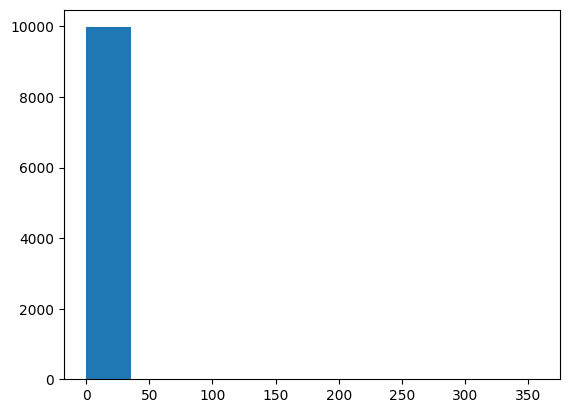

In [26]:
# sim=10000개수 만큼의 Y값 도출
out=fun_Y(5,10000,350)
plt.hist(out,bins=10)
mu, sig = norm.fit(out)
print('평균:',mu, '분산:',sig**2)

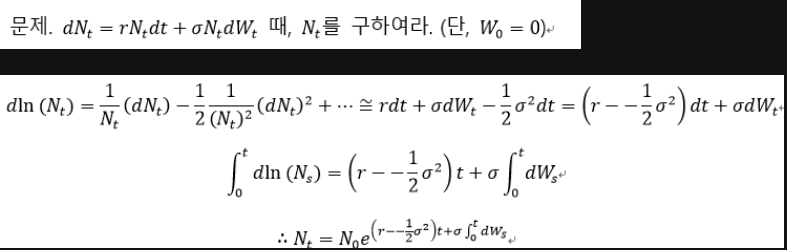

평균: 105.1408629912804 분산: 2.839478611360397


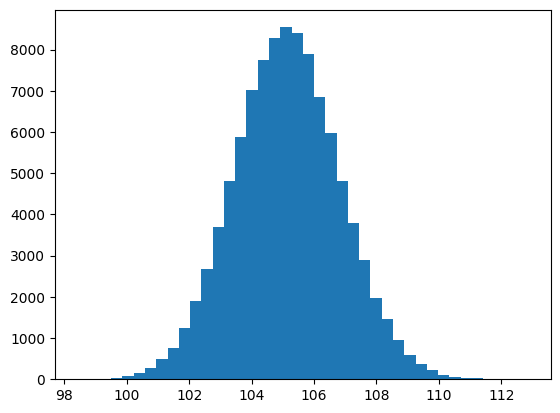

In [28]:
import cupy as cp
from scipy.stats import norm
import matplotlib.pyplot as plt

sim=100000
r,sig=0.05,0.3

# N(0,s)을 따르는 [N, sim] 크기의 정규난수 생성
Z = cp.random.normal(0, s, size=sim)

N = 100*cp.exp(10*(r-0.5*sig**2)+sig*Z)

N_np=cp.asnumpy(N) # numpy array로 변환
plt.hist(N_np,bins=40) # histogram으로 표현
mu, sig = norm.fit(N_np)
print('평균:',mu, '분산:',sig**2)

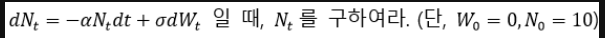

평균: 6.069796207539775 분산: 0.5707900872260165


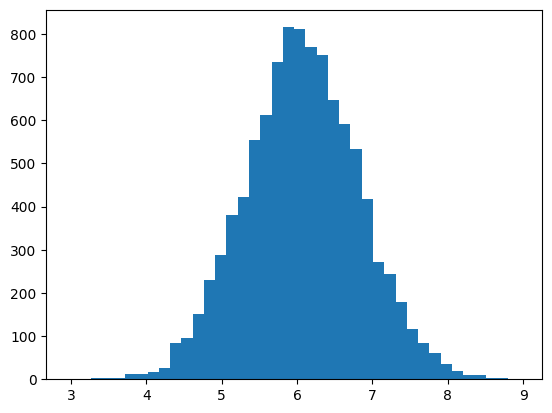

In [30]:
import cupy as cp
from scipy.stats import norm
import matplotlib.pyplot as plt

a,b=0,10
sim,N_intervals=10000,350
T=b-a
N = T * N_intervals  # 만기를 감안한 시간간격의 갯수
dt=T/N
s = cp.sqrt(1 / N_intervals)  # 분산을 표준편차화


# time 행렬 작성하기
t_col=cp.arange(1,N+1)*((b-a)/N) # ih의 값 생성
t_col = t_col[:, cp.newaxis]  # 열(column)로 갖는 행렬로 변환
t_mat=cp.tile(t_col,(1,sim)) # 열 방향으로 sim 개수만큼 복제
zero_row = cp.zeros((1, t_mat.shape[1]), dtype=t_mat.dtype)
# 0으로 이루어진 행을 W의 첫 행에 추가
t_mat = cp.vstack([zero_row, t_mat]) # (N+1,sim)의 행렬로 만든다.

# N(0,s)을 따르는 [N, sim] 크기의 정규난수 생성
dW = cp.random.normal(0, s, size=(N, sim))

alpha,sig=0.05,0.3

# Ito integrand
Integrand= sig*cp.exp(alpha*t_mat[:-1])*dW

# 행방향으로 누적합을 구해가다가 마지막행을 추출
col_sum = cp.cumsum(Integrand, axis=0)[-1,:]

N=cp.exp(-alpha*10)*(10+col_sum)

N_np=cp.asnumpy(N) # numpy array로 변환
plt.hist(N_np,bins=40) # histogram으로 표현
mu, sig = norm.fit(N_np)
print('평균:',mu, '분산:',sig**2)